# Value Function Approximation

Notes from this [lecture](https://www.youtube.com/watch?v=UoPei5o4fps&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ&index=6)

Slides are [here](https://davidstarsilver.wordpress.com/wp-content/uploads/2025/04/lecture-6-value-function-approximation-.pdf).



- So far we looked at the value function as a look up table
- There are too many states / actions
- Solution, approximate the value function, estimate v everywhere


$$
\hat{v}(s, \mathbf{w}) \approx v_{\pi}(s)\\
\hat{q}(s, a, \mathbf{w}) \approx q_{\pi}(s, a)
$$

- We could use any function approximater, examples: Neural Networks, decision trees, linear combinations of features.
- The training data need to be non-stationary, non-iid data
- could use gradient descent

## Initial setup

We'll use [`gymnasium`](https://gymnasium.farama.org/) for creating enviroments that we could use to test various algorithms.

Here is some boilerplate code that helps us train any policy:

In [4]:
def train(env, choose_action, Q_values, update_w, gamma, epsilon, epsilon_decay, epsilon_min,
          num_episodes, verbose=False):

    reward_history = []

    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = choose_action(state, epsilon)

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            total_reward += reward

            # Compute target
            if done:
                td_target = reward
            else:
                td_target = reward + gamma * np.max(Q_values(next_state))

            # TD error
            td_error = td_target - Q_values(state)[action]

            # Gradient update:

            update_w(td_error, state, action)

            state = next_state

        # Epsilon decay
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        reward_history.append(total_reward)
        if verbose:
            print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")
    return reward_history

## Mountain Car Example

Let's try playing around with the mountain car example.

See documation for this example here https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/

Here we approximate the value function as linear mapping from the state:

$$
Q(s, a) = W[a]^T \cdot s
$$

Let's try that with the mountain car example:

[[87.81024083  2.09196533]
 [87.82569363  2.08956492]
 [87.53953789  5.6299117 ]]


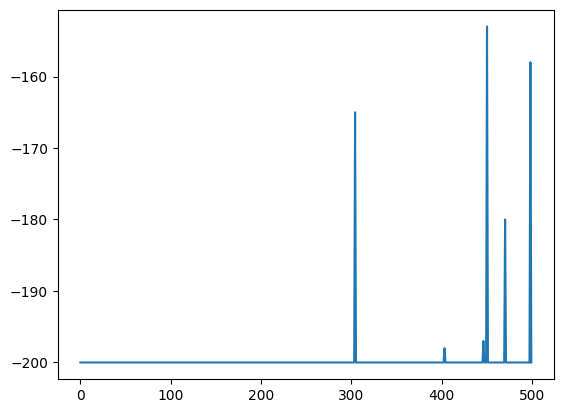

In [10]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import copy


# ----------------------
# Hyperparameters
# ----------------------
alpha = 0.01          # learning rate
gamma = 0.99          # discount
epsilon = 1.0         # exploration
epsilon_min = 0.05
epsilon_decay = 0.995
num_episodes = 500

# ----------------------
# Environment
# ----------------------
env = gym.make("MountainCar-v0")

state_dim = env.observation_space.shape[0]   # 4
n_actions = env.action_space.n               # 2

# ----------------------
# Linear Q-function weights
# W is shape (n_actions, state_dim)
# Q(s, a) = W[a] dot s
# ----------------------
W = np.zeros((n_actions, state_dim))

def Q_values(s):
    """Return Q(s, :) for all actions."""
    return W @ s

def choose_action(state, epsilon):
    """Epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q_values(state))

def update_w(td_error, state, action):
    # Q = w_a^T s  → grad = s
    W[action] += alpha * td_error * state

reward_history = train(env, choose_action, Q_values, update_w, gamma, epsilon, epsilon_decay, epsilon_min, num_episodes)

env.close()

print(W)
plt.plot(reward_history)

**Observations**:

- As you can see we don't converge, that's because the actual Q function is highly non-linear and our simple linear approximation doesn't work
- Also, with the epsilon greedy exploration, we start with a fully random policy, which never actually reaches the goal (a fully random policy will result in the car bouncing right and left at the bottom of the hill and we never push left then push right enough to get us up the hill).


Let's try again but with a non-linear Q-function




[[93.02989636  0.09985351]
 [97.37099283 -0.16030064]
 [96.52464239 -0.28069745]]
[[ 7.81690254e+01  1.28267721e-03]
 [ 7.84854403e+01 -1.76174082e-01]
 [ 7.84755519e+01 -3.25254753e-01]]


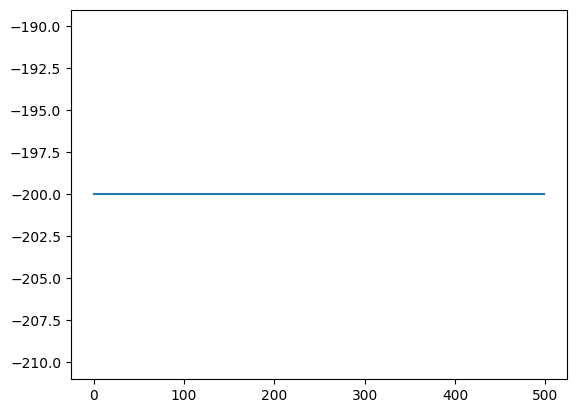

In [11]:
# ----------------------
# Environment
# ----------------------
env = gym.make("MountainCar-v0")

state_dim = env.observation_space.shape[0]   # 4
n_actions = env.action_space.n               # 2

# ----------------------
# Linear Q-function weights
# W is shape (n_actions, state_dim)
# Q(s, a) = W[a] dot s
# ----------------------
W_right = np.zeros((n_actions, state_dim))
W_left = np.zeros((n_actions, state_dim))

def Q_values(s):
    if s[0] < -0.6:
        """Return Q(s, :) for all actions."""
        return W_left @ s
    return W_right @ s

def choose_action(state, epsilon):
    """Epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q_values(state))


def update_w(td_error, state, action):
    # Q = w_a^T s  → grad = s
    if state[0] < -0.6:
        W_left[action] += alpha * td_error * state
    W_right[action] += alpha * td_error * state
    

reward_history = train(env, choose_action, Q_values, update_w, gamma, epsilon, epsilon_decay, epsilon_min, num_episodes)

env.close()

print(W_right)
print(W_left)
plt.plot(reward_history)

Splitting the Q function into 2 halfes didn't work. So let's different. Way


[[ -0.99089316 -14.53643711 -17.2748041  -18.37503033 -17.79460095
  -15.34544138  -0.73929796   0.          -5.54244343 -15.42392606
  -18.73202338 -19.81093396 -19.36373273 -15.55324229 -12.75337151
    0.          -7.46065496 -17.09644767 -20.21840212 -25.46930273
  -24.12122786 -19.9227108  -12.73225919  -6.40624196  -5.65826509
  -14.99061292 -19.59614837 -25.42823222 -26.05421024 -21.06933835
  -12.22145172  -6.89152066  -1.08189537 -10.30836566 -16.67835195
  -19.41041353 -20.21033232 -18.06029004  -9.89812896  -5.44143739
    0.          -3.87625289 -10.02190833 -14.04155134 -13.96390156
  -11.37037934  -7.94772526  -0.27206358   0.           0.
   -3.40355312  -7.43764711  -8.38013354  -5.51015942  -3.97023359
    0.           0.           0.           0.          -1.44038091
   -2.71045031  -1.27753159  -0.14861437   0.           0.
   -3.58642849 -11.09147017 -11.63583902 -13.26706015 -12.15917635
    0.           0.           0.          -9.66908896 -15.75929681
  -16.87533

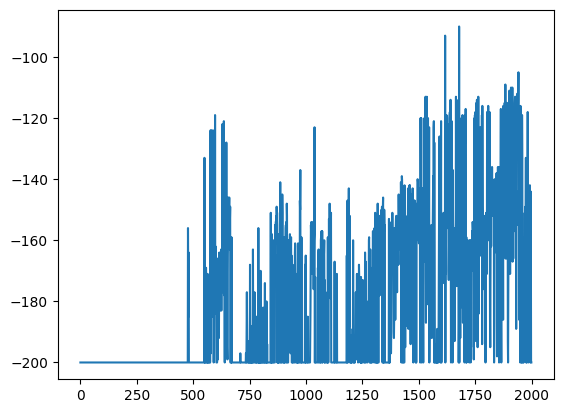

In [73]:
# Hyperparameters
num_episodes = 2000

# Tile coding parameters
num_tilings = 2      # number of overlapping tilings
tiles_per_dim = 8    # tiles along each dimension

# ----------------------
# Environment
# ----------------------
env = gym.make("MountainCar-v0")
state_low = env.observation_space.low
state_high = env.observation_space.high
n_actions = env.action_space.n

# ----------------------
# Tile coding setup
# ----------------------
def tile_encode(state):
    """Return a binary feature vector using multiple tilings."""
    features = np.zeros(num_tilings * tiles_per_dim * tiles_per_dim)
    for tiling in range(num_tilings):
        # Compute offsets
        offsets = (tiling / num_tilings) * (state_high - state_low) / tiles_per_dim
        coords = ((state - state_low + offsets) * tiles_per_dim / (state_high - state_low)).astype(int)
        coords = np.clip(coords, 0, tiles_per_dim - 1)
        index = tiling * tiles_per_dim * tiles_per_dim + coords[0] * tiles_per_dim + coords[1]
        features[index] = 1
    return features

num_features = num_tilings * tiles_per_dim * tiles_per_dim

# ----------------------
# Linear weights: one vector per action
# ----------------------
W = np.zeros((n_actions, num_features))

# ----------------------
# Q function
# ----------------------
def Q_values(s):
    features = tile_encode(s)
    return W @ features

# ----------------------
# Epsilon-greedy action
# ----------------------
def choose_action(s, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q_values(s))

def update_w(td_error, state, action):
    # TD update
    features = tile_encode(state)
    W[action] += alpha * td_error * features

reward_history = train(env, choose_action, Q_values, update_w, gamma, epsilon, epsilon_decay, epsilon_min, num_episodes)

env.close()

print(W)
plt.plot(reward_history)

In [79]:
tile_encode((0.6, -0.05)).reshape((2,8, 8))

array([[[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]]])

In [77]:
W.reshape(3,2,8,8)[0]

array([[[ -0.99089316, -14.53643711, -17.2748041 , -18.37503033,
         -17.79460095, -15.34544138,  -0.73929796,   0.        ],
        [ -5.54244343, -15.42392606, -18.73202338, -19.81093396,
         -19.36373273, -15.55324229, -12.75337151,   0.        ],
        [ -7.46065496, -17.09644767, -20.21840212, -25.46930273,
         -24.12122786, -19.9227108 , -12.73225919,  -6.40624196],
        [ -5.65826509, -14.99061292, -19.59614837, -25.42823222,
         -26.05421024, -21.06933835, -12.22145172,  -6.89152066],
        [ -1.08189537, -10.30836566, -16.67835195, -19.41041353,
         -20.21033232, -18.06029004,  -9.89812896,  -5.44143739],
        [  0.        ,  -3.87625289, -10.02190833, -14.04155134,
         -13.96390156, -11.37037934,  -7.94772526,  -0.27206358],
        [  0.        ,   0.        ,  -3.40355312,  -7.43764711,
          -8.38013354,  -5.51015942,  -3.97023359,   0.        ],
        [  0.        ,   0.        ,   0.        ,  -1.44038091,
          -2.71045

In [59]:
import gymnasium as gym
import numpy as np
import imageio.v3 as iio

frames = []

render_env = gym.make("MountainCar-v0", render_mode="rgb_array")

state, info = render_env.reset()
done = False

def select_action(state):
    return np.argmax(Q_values(state))

while not done:
    # Greedy action using your linear policy (replace with your function)
    action = select_action(state)

    next_state, reward, terminated, truncated, info = render_env.step(action)
    done = terminated or truncated

    frame = render_env.render()   # RGB array frame
    frames.append(frame)

    state = next_state

render_env.close()

# Save frames to MP4 using imageio
iio.imwrite(
    "cartpole_policy.mp4",
    frames,
    fps=30,
    codec="libx264"
)

print("Saved to cartpole_policy.mp4")
from IPython.display import Video
Video("cartpole_policy.mp4", embed=True)



IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved to cartpole_policy.mp4


In [ ]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# ----------------------------
# Q-Network
# ----------------------------
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.net(x)

# ----------------------------
# Hyperparameters
# ----------------------------
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

lr = 1e-3
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
batch_size = 64
buffer_size = 10_000
episodes = 200

replay_buffer = deque(maxlen=buffer_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q_net = DQN(state_dim, action_dim).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# ----------------------------
# Helper: select action
# ----------------------------
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = q_net(state)
        return torch.argmax(q_values).item()

# ----------------------------
# Training Loop
# ----------------------------
for episode in range(episodes):
    state, info = env.reset()
    episode_reward = 0
    done = False

    while not done:
        # Choose action
        action = select_action(state, epsilon)

        # Take step
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        replay_buffer.append((state, action, reward, next_state, done))

        state = next_state
        episode_reward += reward

        # Train
        if len(replay_buffer) > batch_size:
            minibatch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*minibatch)

            states = torch.FloatTensor(states).to(device)
            actions = torch.LongTensor(actions).unsqueeze(1).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            next_states = torch.FloatTensor(next_states).to(device)
            dones = torch.FloatTensor(dones).to(device)

            # Q(s,a)
            q_values = q_net(states).gather(1, actions).squeeze()

            # Target = r + gamma * max_a' Q(next_state)
            with torch.no_grad():
                max_next_q = q_net(next_states).max(1)[0]
                targets = rewards + gamma * max_next_q * (1 - dones)

            loss = loss_fn(q_values, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Epsilon decay
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    print(f"Episode {episode}, Reward: {episode_reward}, Epsilon: {epsilon:.3f}")


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
frames = []

render_env = gym.make("CartPole-v1", render_mode="rgb_array")

state, info = render_env.reset()
done = False

while not done:
    # Greedy action
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        action = torch.argmax(q_net(state_tensor)).item()

    next_state, reward, terminated, truncated, info = render_env.step(action)
    done = terminated or truncated

    # Collect frame
    frame = render_env.render()
    frames.append(frame)

    state = next_state

render_env.close()


fig = plt.figure()
img = plt.imshow(frames[0])

def update(i):
    img.set_data(frames[i])
    return [img]

anim = FuncAnimation(fig, update, frames=len(frames), interval=33)

writer = FFMpegWriter(fps=30)
anim.save("cartpole_policy.mp4", writer=writer)

plt.close()
print("Saved to cartpole_policy.mp4")


In [ ]:
from IPython.display import Video
Video("cartpole_policy.mp4", embed=True)
